##Notebook 02 — Solvency Stress Testing (Asset–Liability Sensitivity)

This notebook performs a forward-looking solvency stress test for an
RWA-backed stablecoin system using the asset-side proxy constructed in
Notebook 01.

Given the absence of a fully transparent, real-time balance sheet for
on-chain RWA protocols, this notebook adopts a reduced-form
asset–liability framework to evaluate how protocol solvency responds to
macroeconomic and valuation shocks.

In particular, the analysis focuses on interest-rate risk and asset
haircuts, two primary drivers of solvency risk for Treasury-backed
stablecoins.

The workflow consists of:

	1.	Loading the asset-side proxy time series produced in Notebook 01
	2.	Inferring an implied liability level using a target collateral ratio
	3.	Defining stress scenarios across interest-rate shocks and valuation haircuts
	4.	Applying a simplified duration-based valuation model to stressed assets
	5.	Computing post-shock collateral ratios under each scenario
	6.	Visualizing solvency boundaries using curve plots and heatmaps

The output of this notebook provides a scenario-based solvency surface
that highlights regions of capital adequacy, vulnerability, and potential
insolvency.

These results form the analytical foundation for the liquidity and
redemption stress analysis conducted in Notebook 03.

In [ ]:
# Setup: latest repo state into Colab runtime
%cd /content
!rm -rf rwa-stablecoin-risk-spark
!git clone https://github.com/lydialydia-lydia/rwa-stablecoin-risk-spark.git
%cd /content/rwa-stablecoin-risk-spark

!ls
!ls data

/content
Cloning into 'rwa-stablecoin-risk-spark'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 69 (delta 29), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (69/69), 510.62 KiB | 12.16 MiB/s, done.
Resolving deltas: 100% (29/29), done.
/content/rwa-stablecoin-risk-spark
data  figures  LICENSE	notebooks  README.md
spark_assets_proxy.csv


In [ ]:
import pandas as pd

# Load protocol TVL proxy (asset-side time series)
tvl = pd.read_csv("data/spark_assets_proxy.csv")
tvl["date"] = pd.to_datetime(tvl["date"])

tvl.head()

,date,assets_proxy_usd
0,2023-05-01,31.0
1,2023-05-02,30.0
2,2023-05-03,31.0
3,2023-05-04,31.0
4,2023-05-05,31.0


In [ ]:
# Latest asset proxy level (USD)
A0 = float(tvl["assets_proxy_usd"].iloc[-1])

# Choose a current collateral ratio assumption (A0 / L0)
target_cr_now = 1.05

# Back out implied liabilities so that current CR matches target
L0 = A0 / target_cr_now

A0, L0

(6045493459.4783, 5757612818.550762)

In [ ]:
import numpy as np
import pandas as pd

# Stress scenario inputs
# Parallel rate shocks (in basis points)
rate_shocks_bp = np.array([0, 50, 100, 150, 200, 300])

# Valuation / liquidation friction haircuts on the asset side
haircuts = np.array([0.00, 0.02, 0.05, 0.10])

# Simplified rate sensitivity (Treasury-like duration proxy)
duration_years = 1.0  # 1-year effective duration (toy assumption)

def stress_assets(A0: float, haircut: float, rate_shock_bp: float, duration_years: float) -> float:
    """
    Apply a simple mark-to-market stress:
    - haircut reduces value directly (liquidation / valuation friction)
    - duration approximation: dP/P ≈ -Duration * dy
    """
    dy = rate_shock_bp / 10_000  # bp -> decimal yield change
    return A0 * (1 - haircut) * (1 - duration_years * dy)

# Generate scenario table (Cartesian product)
scenario_grid = pd.MultiIndex.from_product(
    [haircuts, rate_shocks_bp], names=["haircut", "rate_shock_bp"]
).to_frame(index=False)

# Compute stressed assets and collateral ratio
scenario_grid["asset_value_usd"] = scenario_grid.apply(
    lambda r: stress_assets(A0, r["haircut"], r["rate_shock_bp"], duration_years),
    axis=1
)
scenario_grid["collateral_ratio"] = scenario_grid["asset_value_usd"] / L0

results = scenario_grid.sort_values(["haircut", "rate_shock_bp"]).reset_index(drop=True)
results

,haircut,rate_shock_bp,asset_value_usd,collateral_ratio
0,0.00,0,6.045493e+09,1.050000
1,0.00,50,6.015266e+09,1.044750
2,0.00,100,5.985039e+09,1.039500
3,0.00,150,5.954811e+09,1.034250
4,0.00,200,5.924584e+09,1.029000
5,0.00,300,5.864129e+09,1.018500
6,0.02,0,5.924584e+09,1.029000
7,0.02,50,5.894961e+09,1.023855
8,0.02,100,5.865338e+09,1.018710
9,0.02,150,5.835715e+09,1.013565


saved: /content/rwa-stablecoin-risk-spark/figures/collateral_ratio_curve.png


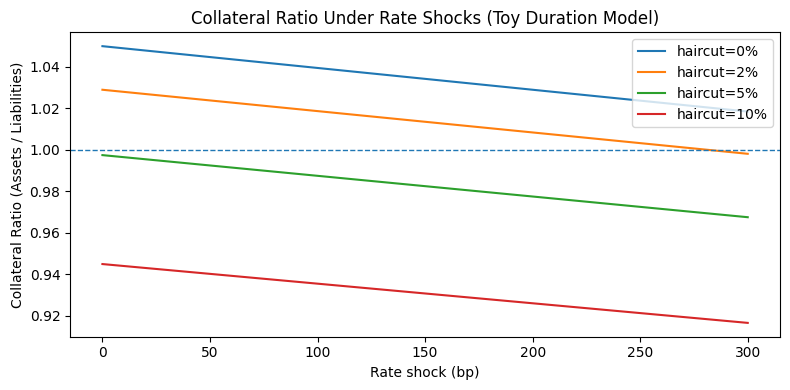

In [ ]:
import os
import matplotlib.pyplot as plt

os.makedirs("figures", exist_ok=True)
plt.figure(figsize=(8, 4))

# Plot CR vs. rate shock, one line per haircut scenario
for h in haircuts:
    sub = results[results["haircut"] == h].sort_values("rate_shock_bp")
    plt.plot(sub["rate_shock_bp"], sub["collateral_ratio"], label=f"haircut={h:.0%}")

plt.axhline(1.0, linestyle="--", linewidth=1)  # CR=1 boundary means assets == liabilities (insolvency boundary)
plt.xlabel("Rate shock (bp)")
plt.ylabel("Collateral Ratio (Assets / Liabilities)")
plt.title("Collateral Ratio Under Rate Shocks (Toy Duration Model)")
plt.legend()
plt.tight_layout()

# Save the plot
out1 = "figures/collateral_ratio_curve.png"
plt.savefig(out1, dpi=200, bbox_inches="tight")
print("saved:", os.path.abspath(out1))

plt.show()
plt.close()

saved: /content/rwa-stablecoin-risk-spark/figures/collateral_ratio_heatmap.png


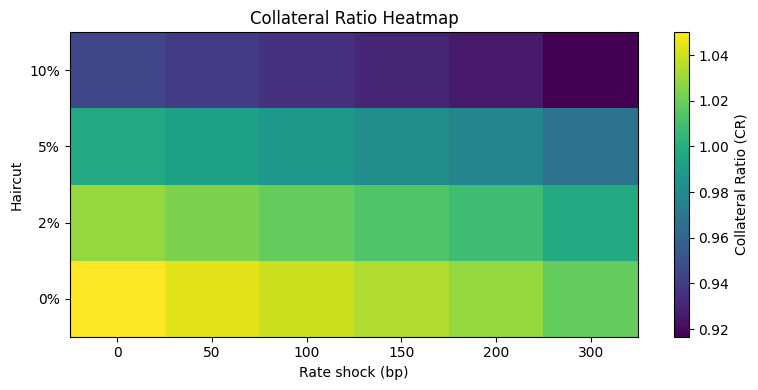

In [ ]:
import os
import matplotlib.pyplot as plt

os.makedirs("figures", exist_ok=True)

# Reshape results into a grid:
# rows = haircut, columns = rate shock, values = collateral ratio
pivot = (
    results.pivot(index="haircut", columns="rate_shock_bp", values="collateral_ratio")
    .sort_index()
    .sort_index(axis=1)
)

# Heatmap: visualize CR across the (haircut x shock) scenario grid
plt.figure(figsize=(8, 4))
im = plt.imshow(pivot.values, aspect="auto", origin="lower")

# Tick labels should match the pivot grid ordering
plt.xticks(range(len(pivot.columns)), pivot.columns)
plt.yticks(range(len(pivot.index)), [f"{h:.0%}" for h in pivot.index])

plt.xlabel("Rate shock (bp)")
plt.ylabel("Haircut")
plt.title("Collateral Ratio Heatmap")
plt.colorbar(im, label="Collateral Ratio (CR)")
plt.tight_layout()

# Save the image
out2 = "figures/collateral_ratio_heatmap.png"
plt.savefig(out2, dpi=200, bbox_inches="tight")
print("saved:", os.path.abspath(out2))

plt.show()
plt.close()